# Predicting Boston Housing Prices - Model Evaluation & Validation

## Getting Started
In this project, we evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

Below code cell load the Boston housing dataset, along with a few of the necessary Python libraries required for this project. The dataset is loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


## Data Exploration
In this first section of this project, we make a cursory investigation about the Boston housing data and analyse our observations. Familiarizing ourself with the data through an explorative process is a fundamental practice to help you better understand and justify your results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we would need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Calculate Statistics
First we calculate descriptive statistics about the Boston housing prices. Since `numpy` has already been imported for us, we use this library to perform the necessary calculations. These statistics will be important later on to analyze various prediction results from the constructed model.

The code cell below calculates the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`. It also stores each calculation in their respective variable.

In [2]:
# Minimum price of the data
minimum_price = np.amin(prices)

# Maximum price of the data
maximum_price = np.amax(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105000.0
Maximum price: $1024800.0
Mean price: $454342.9447852761
Median price $438900.0
Standard deviation of prices: $165171.13154429474


### Note 1 - Feature Observation
We are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.


Using our intuition, for each of the three features above, we can observe:

`'RM'`: Increase in `'RM'` intuitively should **increase** the value of a house (`'MEDV'`) because the more room a house has, the more likely it will have bigger area (square feet) and subsequently it will cost more.

`'LSTAT'`: Increase in `'LSTAT'` would probably **decrease** the value of a house (`'MEDV'`) because the more low-income homeowners in a neighborhood mean that they have probably bought cheaper houses.

`'PTRATIO'`: Increase in `'PTRATIO'` seems to have a negative impact on the value of `'MEDV'` and **decrease** it. Because the more students per teacher in a neighborhood probably means that neighborhood is denser and has lower resources which implies that probably that neighborhood has lower quality and subsequently lower house prices. However after looking more closely, the influence of `'PTRATIO'` on house prices doesn't seem to be as significant as `'RM'` and `'LSTAT'`.

----

## Developing a Model
In this second section of the project, you will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, we will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify our model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

The code cell below uses `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`. It also assigns the performance score to the `score` variable.

In [3]:
from sklearn.metrics import r2_score
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculating the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Returning the score
    return score

### Note 2 - Goodness of Fit
We assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

The code cell below uses the `performance_metric` function and calculate this model's coefficient of determination.

In [4]:
# Calculating the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


We know that the R<sup>2</sup> score is the proportion of the variance in the dependent variable that is predictable from the independent variable. In other words:

* R<sup>2</sup> score of 0 means that the dependent variable cannot be predicted from the independent variable.
* R<sup>2</sup> score of 1 means the dependent variable can be predicted from the independent variable.
* R<sup>2</sup> score between 0 and 1 indicates the extent to which the dependent variable is predictable.
* R<sup>2</sup> score of 0.40 means that 40 percent of the variance in Y is predictable from X.

We observe that because the calculated R<sup>2</sup> for this dataset is very close to 1, the model can predict the target variable with a high confidence. That's because a closer value to 1 suggests a high percentage of squared correlation between the predicted and actual values of the target variable.

### Shuffle and Split Data
Now we take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

The code cell below:
- Uses `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Splits the data into 80% training and 20% testing.
  - Sets the `random_state` for `train_test_split` to a value of choice. This ensures results are consistent.
- Assigns the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [5]:
# Importing 'train_test_split'
from sklearn.cross_validation import train_test_split

# Shuffling and spliting the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.20, random_state=63)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


### Note 3 - Training and Testing

Splitting data allows us to use a new set of data for our testing, which means that for testing, we won't use the data which we already used for training. Because we want our model to be able to predict data for unseen features, we need to put aside some samples as our testing data. When we finished training our model, we can then use those testing data to see how our model is doing in situations which it has not seen directly.

We also need to make sure that we have enough data when we do splitting. Especially for training, we need our model to train with enough data to be able to predict confidently so we can avoid underfitting.

----

## Analyzing Model Performance
Now we take a look at several models' learning and testing performances on various subsets of training data. Additionally, we investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing our model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. The shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

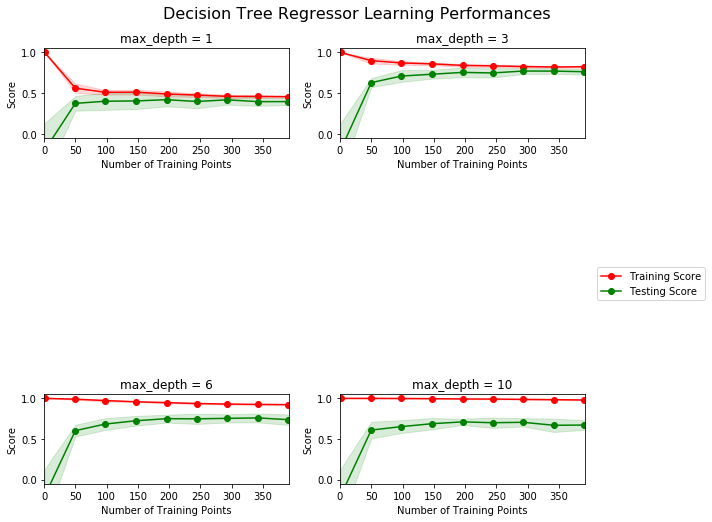

In [6]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Note 4 - Learning the Data

We can observe that for the graph with maximum depth of 3, as more training points are added, the training scores decreases a little bit and the testing score increases, until they converge to almost a same score around 0.8 which means that our model is doing good in prediction.

We can also see in models with max depth of 6 and 10, that increasing the number of data points don't improve the performance of our model. Changing our model's max depth from 3 to 6 will slightly increase the performance of our training score but doesn't change our training score and the two lines' distances increases a little bit which means it's going towards a possible overhitting. Similarly changing from max depth of 6 to 10 will even more increase the distance between training score and testing score and they will never reach out together which means our model has been over-fitted.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.

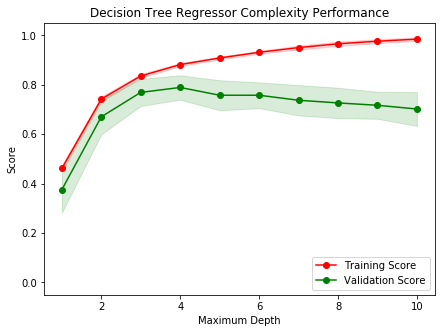

In [7]:
vs.ModelComplexity(X_train, y_train)

### Note 5 - Bias-Variance Tradeoff

We can observe that when the model is trained with a maximum depth of 1 it suffers from high bias because it has been trained too simplistically so there is an underfitting. When the model is trained with a maximum depth of 10, we see that there has been unnecessary complexity which implies that there is an overfitting in our model.

### Note 6 - Best-Guess Optimal Model

We also understand that the model does the best predictions in the depth of 3. Based on the graph, at depth of 3, there is the lowest distance between training score and validation score. Moreover, at this depth, the validation score is almost at its highest point and it seems to be reliable without complicating the model.

-----

## Evaluating Model Performance
In this final section of the project, we will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

Grid search is a process to select an optimal learning model that fits our data by examining different variables that can improve the performance of our model (hyper parameters). In this method we divide our dataset into three datasets. The majority of our data will be our training data, and the rest will be divided into validation data and testing data. We then train our model using our training data by examining different candidate models or in another words different hyper parameters (e.g. max depth in this project) and select the best model which has the best performance (e.g. R<sup>2</sup> score close to 1 in this project) as our best candidate model. Finally, we test our best scored model using our testing data to make sure it works fine. 

P.S. The word grid means examining all possible combination of hyper parameters which we use in evaluating our models' performances.

### Note 8 - Cross-Validation
We can also use k-fold cross validation to help grid search. K-fold cv is a validation method in which we divide our "training" data into K different subsets and then train our model K times in a way that each time we use different subsets (K-1 subsets) of our training data to train our model and another 1 set of our training model as our validation data. We then repeat our training K times each time with different combinations of subsets (each time using different subset as the validation subset). Finally we average the performance results of each round of trainings to come up the final model performance. That will ensure that our model will not be based on a specific order or splitting and we will be able to have an unbiased prediction on unseen data.

K-fold method can be very useful in combination with grid search. It allows us to train our model K times instead of only 1 time and average the results. This combination will increase the reliability of our model by considering the effect of data variation in training the model. To do so in grid search we run k-fold cv on each combination of our hyperparameters to select the best combination for our model.

### Fitting a Model
Our final implementation requires that we bring everything together and train a model using the **decision tree algorithm**. To ensure that we are producing an optimized model, we will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, this implementation uses `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique we described in **Note 8**, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*.

ShuffleSplit has different parameters in new versions of scikit-learn 0.18+.
For the `fit_model` function in the code cell below, we will need to implement the following:
- use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [8]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Creating cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)

    # Creating a decision tree regressor object
    regressor = DecisionTreeRegressor(random_state=0)

    # Creating a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10]}

    # Transforming 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Creating the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. You can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Note 9 - Optimal Model

The code block below fits the decision tree regressor to the training data and produce an optimal model.

In [9]:
# Fitting the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 3 for the optimal model.


The optimal model have the max depth of 4. This is 1 more than what I intuitively guessed in Note 6. This seems reasonable as the the model with max depth of 3 and 4 have close validation and training scores.

### Note 10 - Predicting Selling Prices
Imagine that we were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

The code block below uses our optimized model to make predictions for each client's home.

In [10]:
# Producing a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Showing predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $380,609.09
Predicted selling price for Client 2's home: $277,491.09
Predicted selling price for Client 3's home: $913,920.00


The prices seem reasonable as the client 3 has the most expensive house and client 2 has the cheapest house. That also makes sense when we compare them to the statistics we calculated in the Data Exploration section. Client 3's house price is obviously above the mean and median with high deviation from mean while client 2's house price is below the mean and median and client 1's house price is around the average.

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

The code cell below runs the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.

In [11]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $419,700.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $402,531.82
Trial 10: $413,700.00

Range in prices: $29,438.89


### Note 11 - Applicability

In overall, the constructed model seems to be usable in real-world setting but it seems that there are many room to improving it.

Firstly, since the price range calculated in note 10 is not significant, the predictor can be reasonably close enough to the real-worl prices. Secondly we considered the inflamation by using the multiplicatively scaled features so the predication based on 1987 can be reliable enough by considering the inflamtion.

However considering the fact that there are other more important features of a house such a square feet, age of the house, whether it is in a rural area or urban area that impact its price, they might be also factored in to have a more reliable model. Also since each neghborhood might have different policies which migh impact the price of the house, for having a more holistic model we might need to eliminate the neghborhood factor from our model

In a nutshel it seems the model is reliable enough to be used to make predication but it can be improved to have more robust and consitent predictions by adding more features to it.